In [3]:
cd /content/drive/MyDrive/Thesis_Organized

/content/drive/MyDrive/Thesis_Organized


In [4]:
import os
from tqdm import tqdm
main_dir = os.getcwd()

In [3]:
# importing
from Detectron2.detectron_params import *

In [4]:
# check for GPU availability

!nvidia-smi

Thu Jul 27 12:12:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [6]:
# Setups
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [7]:
import detectron2
# from detectron2.utils.logger import setup_logger
# setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import os

In [8]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, COCO_LABELS_TRAIN_DIR, os.path.join(main_dir, CROPPED_IMAGES_DIR, "Train"))
register_coco_instances("my_dataset_test", {}, COCO_LABELS_TEST_DIR, os.path.join(main_dir, CROPPED_IMAGES_DIR, "Test"))
register_coco_instances("my_dataset_val", {}, COCO_LABELS_TAL_DIR, os.path.join(main_dir, CROPPED_IMAGES_DIR, "Val"))

In [9]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced


    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [ ]:
from detectron2.data import DatasetMapper, build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.data.transforms import RandomApply, RandomBrightness, RandomRotation, RandomFlip, RandomCrop, RandomContrast
from detectron2.config import CfgNode
from detectron2.solver.build import get_default_optimizer_params, maybe_add_gradient_clipping



class CustomTrainer(DefaultTrainer):
    """
    Custom Trainer deriving from the "DefaultTrainer"

    Overloads build_hooks to add a hook to calculate loss on the test set during training.
    """

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(
            20, # Frequency of calculation - every 20 iterations here
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg, True)
            )
        ))

        return hooks

    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=[RandomApply(RandomBrightness(0.8,1.2),0.2),
                                                                  RandomApply(RandomRotation(angle = [20,340]),0.2),
                                                                  RandomApply(RandomFlip(),0.2),
                                                                  RandomApply(RandomCrop(crop_type = "relative", crop_size = (0.8,0.8)),0.2),
                                                                  RandomApply(RandomContrast(0.8,1.2),0.2)])
        return build_detection_train_loader(cfg, mapper=mapper)


    @classmethod
    def build_optimizer(cls, cfg: CfgNode, model: torch.nn.Module) -> torch.optim.Optimizer:
        """
        Build an optimizer from config.
        """
        params = get_default_optimizer_params(
            model,
            base_lr=cfg.SOLVER.BASE_LR,
            weight_decay_norm=cfg.SOLVER.WEIGHT_DECAY_NORM,
            bias_lr_factor=cfg.SOLVER.BIAS_LR_FACTOR,
            weight_decay_bias=cfg.SOLVER.WEIGHT_DECAY_BIAS,
        )
        return maybe_add_gradient_clipping(cfg, torch.optim.Adam)(
            params,
            lr=cfg.SOLVER.BASE_LR,
            weight_decay=cfg.SOLVER.WEIGHT_DECAY,
        )

In [12]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "./Detectron2/output_numiter_lr_modelid"
cfg.merge_from_file(model_zoo.get_config_file(MODELS_LIST[1]))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.SOLVER.MOMENTUM = MOMENTUM
cfg.SOLVER.CHECKPOINT_PERIOD = 200  # The network takes a checkpoint once it finishes of every 200 iterations
# cfg.TEST.EVAL_PERIOD = 20
cfg.DATALOADER.NUM_WORKERS = NUM_WORKERS
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODELS_LIST[1])  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = IMS_PER_BATCH  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = BASE_LR  # pick a good LR
cfg.SOLVER.MAX_ITER = MAX_ITER    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE_PER_IMAGE  # The "RoIHead batch size". 128 is faster, and good enough for this dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  # only has one class (Track). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=True)
# trainer.train()

[07/27 12:21:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [7]:
import json

with open(os.path.join(cfg.OUTPUT_DIR, "metrics.json"), 'r') as handle:
    json_data = [json.loads(line) for line in handle]

In [13]:
training_loss = []
validation_loss = []
iteration = []

for i in json_data:
  if "iteration" in i.keys():
    iteration.append(i["iteration"])
  else:
    iteration.append(iteration[-1])

  if "total_loss" in i.keys():
    training_loss.append(i["total_loss"])
  else:
    training_loss.append(training_loss[-1])

  if "validation_loss" in i.keys():
    validation_loss.append(i["validation_loss"])
  else:
    validation_loss.append(validation_loss[-1])

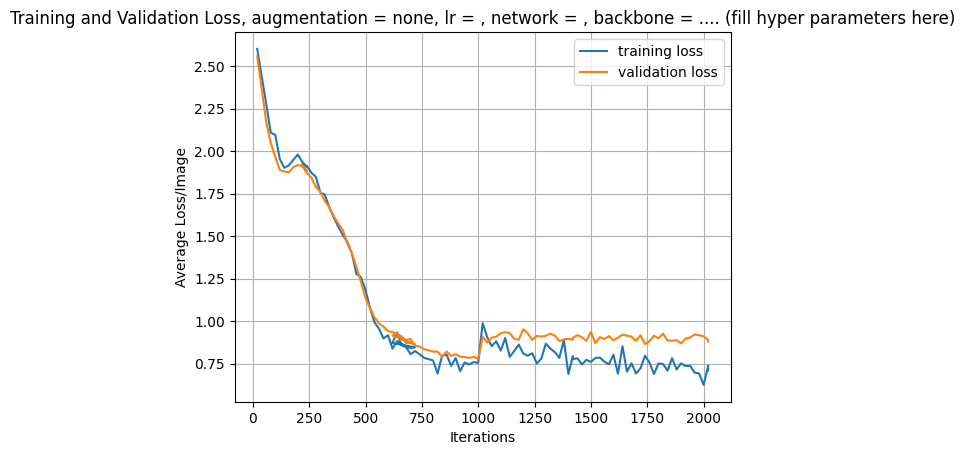

In [14]:
import matplotlib.pyplot as plt


plt.plot(iteration, training_loss, label = "training loss")
plt.plot(iteration, validation_loss, label = "validation loss")
plt.xlabel("Iterations")
plt.ylabel("Average Loss/Image")
plt.title("Training and Validation Loss, augmentation = none, lr = , network = , backbone = .... (fill hyper parameters here)")
plt.legend()
plt.grid()
plt.show()

In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[07/27 12:22:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./Detectron2/output_numiter_lr_modelid/model_final.pth ...


In [20]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", output_dir=os.path.join(cfg.OUTPUT_DIR, "inference"))
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [07/27 12:22:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/27 12:22:26 d2.data.datasets.coco]: Loaded 98 images in COCO format from Data/COCO format/coco_test_data.json
[07/27 12:22:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/27 12:22:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/27 12:22:26 d2.data.common]: Serializing 98 elements to byte tensors and concatenating them all ...
[07/27 12:22:26 d2.data.common]: Serialized dataset takes 0.52 MiB
[07/27 12:22:26 d2.evaluation.evaluator]: Start inference on 98 batches


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/27 12:22:33 d2.evaluation.evaluator]: Inference done 11/98. Dataloading: 0.2238 s/iter. Inference: 0.1149 s/iter. Eval: 0.0018 s/iter. Total: 0.3406 s/iter. ETA=0:00:29
[07/27 12:22:38 d2.evaluation.evaluator]: Inference done 29/98. Dataloading: 0.1917 s/iter. Inference: 0.1164 s/iter. Eval: 0.0023 s/iter. Total: 0.3105 s/iter. ETA=0:00:21
[07/27 12:22:43 d2.evaluation.evaluator]: Inference done 43/98. Dataloading: 0.2078 s/iter. Inference: 0.1177 s/iter. Eval: 0.0027 s/iter. Total: 0.3283 s/iter. ETA=0:00:18
[07/27 12:22:48 d2.evaluation.evaluator]: Inference done 61/98. Dataloading: 0.1916 s/iter. Inference: 0.1178 s/iter. Eval: 0.0028 s/iter. Total: 0.3123 s/iter. ETA=0:00:11
[07/27 12:22:54 d2.evaluation.evaluator]: Inference done 78/98. Dataloading: 0.1899 s/iter. Inference: 0.1177 s/iter. Eval: 0.0028 s/iter. Total: 0.3105 s/iter. ETA=0:00:06
[07/27 12:22:59 d2.evaluation.evaluator]: Inference done 94/98. Dataloading: 0.1898 s/iter. Inference: 0.1181 s/iter. Eval: 0.0029 s/it

In [7]:
import pandas as pd

data_path = "/content/drive/MyDrive/Thesis/annotations_csv"
df = pd.read_csv(data_path).drop(columns = ["Unnamed: 0"])
df.head()

,id,name,track,z_order,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,folder,bbox_x,bbox_y,bbox_width,bbox_height,segmentation
0,0,L1Ap5_1-1-109.png,Track1,0,411.65,248.47,312.63,149.45,223.32,36.45,Train,209.48,254.64,217.19,239.21,"[217.19, 27.01, 215.91, 28.29, 214.62, 29.58, ..."
1,0,L1Ap5_1-1-109.png,Track2,0,384.92,256.98,339.97,263.66,406.79,249.08,Train,327.71,237.92,93.82,43.73,"[399.68, 239.21, 398.4, 240.5, 397.11, 240.5, ..."
2,1,L1Ap5_1-1-142.png,Track1,0,567.18,283.10,495.49,275.20,440.15,264.27,Val,427.96,218.63,151.65,48.87,"[435.67, 253.36, 434.38, 254.64, 433.1, 254.64..."
3,1,L1Ap5_1-1-142.png,Track2,0,316.88,223.56,243.37,181.04,130.37,128.18,Val,116.95,279.08,214.62,124.75,"[127.23, 117.03, 125.95, 118.32, 124.66, 118.3..."
4,1,L1Ap5_1-1-142.png,Track3,0,364.27,251.51,356.98,269.74,347.26,291.61,Val,332.86,210.92,46.27,66.88,"[355.99, 243.07, 354.7, 244.35, 354.7, 245.64,..."


In [8]:
def correct_segmentations(seg):
  corrected_seg = []
  for i in seg[1:-1].split(","):
    corrected_seg.append(float(i))
  return corrected_seg

In [ ]:
im = cv2.imread("/content/drive/MyDrive/Thesis/Images_cropped/Test/L1Ap5_7-1-82.png")
outputs = predictor(im)
outputs

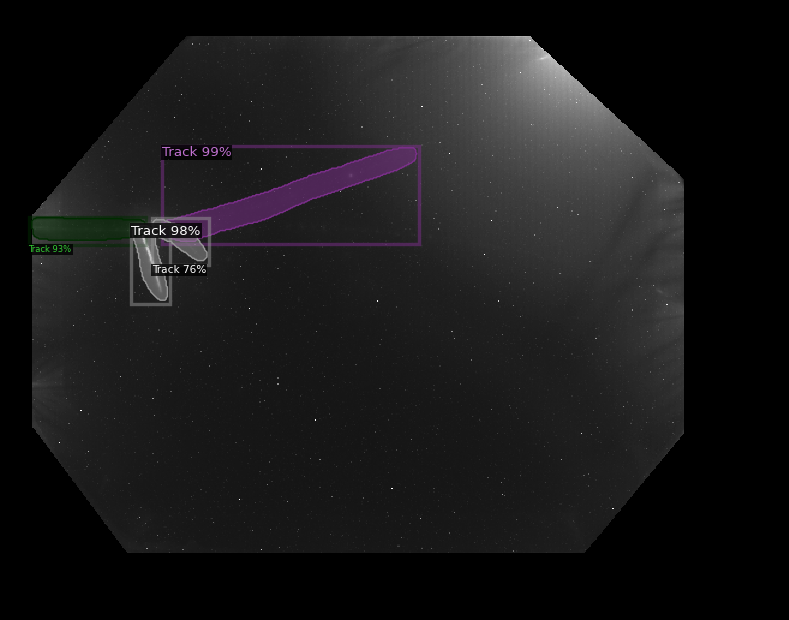

In [24]:
# Inference with a keypoint detection model
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

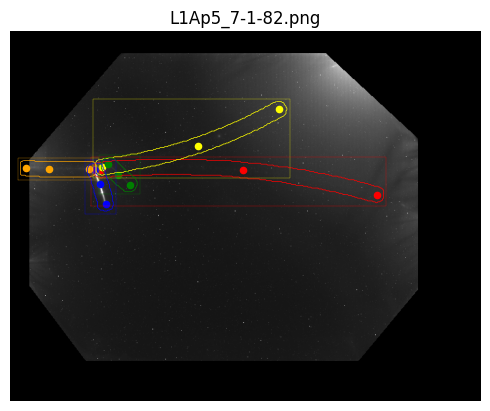

In [25]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

gt_path = "/content/drive/MyDrive/Thesis/Images_cropped"
def plot_img_points_bbox_segcontour(gt_path, labels_df, idx):
  # idx = random.randint(0, labels_df.shape[0])
  img_path = os.path.join(gt_path, labels_df.folder[idx], labels_df.name[idx])
  title = labels_df.name[idx]
  # Read in the image and plot it using matplotlib
  img = mpimg.imread(img_path)
  plt.imshow(img, cmap = "gray")
  colors = ["red", "yellow", "green", "blue", "orange", "pink", "violet", "midnightblue", "tan", "palegreen"]


  image_name = labels_df.name[idx]
  view = labels_df.name == image_name


  points = labels_df.loc[view, ['p1_x', 'p1_y', 'p2_x', 'p2_y','p3_x', 'p3_y']].values
  bbox = labels_df.loc[view, ["bbox_x", "bbox_y", "bbox_width", "bbox_height"]].values.copy()
  segmentation = labels_df.loc[view, "segmentation"].values.copy()
  for j in range(points.shape[0]):
    plt.scatter([points[j,0], points[j,2], points[j,4]], [points[j,1], points[j,3], points[j,5]], color=colors[j], s = 20)
    # plt.scatter(np.array([points[0], points[2], points[4]]), np.array([points[1], points[3], points[5]]), color= "red", s = 2)


    bbox_x = np.array([bbox[j][0], bbox[j][0] + bbox[j][2], bbox[j][0] + bbox[j][2], bbox[j][0], bbox[j][0]])
    bbox_y = np.array([img.shape[0] - bbox[j][1], img.shape[0] - bbox[j][1],
                      img.shape[0] - bbox[j][1]-bbox[j][3],
                      img.shape[0] - bbox[j][1]-bbox[j][3],
                      img.shape[0] - bbox[j][1]])
    # bbox_x = np.array([bbox[0], bbox[0] + bbox[2], bbox[0] + bbox[2], bbox[0], bbox[0]])
    # bbox_y = np.array([img.shape[0] - bbox[1], img.shape[0] - bbox[1],
    #                  img.shape[0] - bbox[1]-bbox[3],
    #                  img.shape[0] - bbox[1]-bbox[3],
    #                  img.shape[0] - bbox[1]])
    plt.plot(bbox_x, bbox_y, color = colors[j], linewidth = 0.2)


    x_segmentation = np.array(correct_segmentations(segmentation[j])[::2])
    y_segmentation = np.array(correct_segmentations(segmentation[j])[1::2])
    plt.plot(x_segmentation, y_segmentation, color = colors[j], linewidth = 0.5)


  plt.title(title)
  plt.axis("off");

  # print(f"Image shape: {img.shape}") # show the shape of the image

  return img


img = plot_img_points_bbox_segcontour(gt_path, df, 1093)

In [26]:
outputs["instances"].pred_masks.shape

torch.Size([4, 517, 658])

In [12]:
pwd

'/content/drive/MyDrive/Thesis_Organized'

In [50]:
def evaluate_instance(gt_lst, outputs):

  instances = len(gt_lst)
  predictions = outputs.shape[0]
  eval = np.ones((instances, predictions)) * -1

  for i in range(instances):
    for j in range(predictions):
      intersection = np.logical_and(gt_lst[i], outputs[j, :, :]).sum()
      union = np.logical_or(gt_lst[i], outputs[j, :, :]).sum()
      eval[i, j] = intersection/union
  return eval

In [64]:
from tqdm import tqdm

test = df[df.folder == "Test"].copy()
test = test.reset_index().drop(columns = ["index"])
output_dict = {}

for image in tqdm(np.unique(test.name.values)):
  temp = test[test.name == image].copy()
  im_dir = os.path.join(main_dir, CROPPED_IMAGES_DIR, temp.folder.values[0], image)
  im = cv2.imread(im_dir)
  outputs = predictor(im)
  outputs = outputs["instances"].pred_masks.to("cpu").numpy()
  gt_lst = []
  for instance in temp.track:
    gt_dir = os.path.join(main_dir, GROUND_TRUTH_DIR, temp.folder.values[0], temp.name.values[0][:-4], instance + ".png")
    gt = cv2.imread(gt_dir)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    gt = cv2.resize(gt, (658, 517), interpolation = cv2.INTER_AREA)
    gt = gt.astype("bool")
    gt_lst.append(gt)

  output_dict[image] = evaluate_instance(gt_lst, outputs)

100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


In [ ]:
output_dict

In [68]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open(os.path.join(cfg.OUTPUT_DIR, "test_results.p"), 'wb') as fp:
    pickle.dump(output_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open(os.path.join("./Detectron2/output_numiter_lr_modelid", "test_results.p"), 'rb') as fp:
    output_dict = pickle.load(fp)

In [70]:
import numpy as np

def FP_FN_0(output_dict: dict):

  out = 0
  for img in tqdm(output_dict.keys()):
    con_mat_shape = output_dict[img].shape
    if con_mat_shape[0] != con_mat_shape[1]:
      continue
    else:
      tps = output_dict[img] > 0.5
      if (tps.sum(axis = 0) == np.ones(con_mat_shape[0])).all() and (tps.sum(axis = 1) == np.ones(con_mat_shape[0])).all():
        out += 1
  return out

def TP(output_dict: dict):

    out = 0
    for img in tqdm(output_dict.keys()):
      cf_mat = output_dict[img].copy()
      con_mat_shape = cf_mat.shape
      for i in range(con_mat_shape[1]):
        idx = cf_mat[:, i].argmax()
        if cf_mat[idx, i] > 0.5:
          out += 1
          cf_mat[idx, :] = 0
          cf_mat[:, i] = 0
    return out

def FP(output_dict: dict):

  out = 0
  for img in tqdm(output_dict.keys()):
      cf_mat = output_dict[img].copy()
      con_mat_shape = cf_mat.shape
      for i in range(con_mat_shape[1]):
        if (cf_mat[:, i] > 0.5).sum() == 0:
          out += 1
  return out

def TP_0(output_dict: dict):

  out = 0
  for img in tqdm(output_dict.keys()):
      cf_mat = output_dict[img].copy()
      con_mat_shape = cf_mat.shape
      flag = True
      for i in range(con_mat_shape[1]):
        if (cf_mat[:, i] > 0.5).sum() != 0:
          flag = False
      if flag:
        out += 1
  return out

In [66]:
FP_FN_0(output_dict)

100%|██████████| 100/100 [00:00<00:00, 46926.65it/s]


42

In [67]:
TP(output_dict)

100%|██████████| 100/100 [00:00<00:00, 32229.17it/s]


249

In [68]:
FP(output_dict)

100%|██████████| 100/100 [00:00<00:00, 33243.27it/s]


72

In [71]:
TP_0(output_dict)

100%|██████████| 100/100 [00:00<00:00, 19418.07it/s]


0

In [75]:
249/(249+72), 249/324

(0.7757009345794392, 0.7685185185185185)

325

In [13]:
cfg.keys()

dict_keys(['VERSION', 'MODEL', 'INPUT', 'DATASETS', 'DATALOADER', 'SOLVER', 'TEST', 'OUTPUT_DIR', 'SEED', 'CUDNN_BENCHMARK', 'VIS_PERIOD', 'GLOBAL'])

In [17]:
cfg.SOLVER

CfgNode({'LR_SCHEDULER_NAME': 'WarmupMultiStepLR', 'MAX_ITER': 100, 'BASE_LR': 0.00016, 'BASE_LR_END': 0.0, 'MOMENTUM': 0.9, 'NESTEROV': False, 'WEIGHT_DECAY': 0.0001, 'WEIGHT_DECAY_NORM': 0.0, 'GAMMA': 0.1, 'STEPS': [], 'NUM_DECAYS': 3, 'WARMUP_FACTOR': 0.001, 'WARMUP_ITERS': 1000, 'WARMUP_METHOD': 'linear', 'RESCALE_INTERVAL': False, 'CHECKPOINT_PERIOD': 5000, 'IMS_PER_BATCH': 8, 'REFERENCE_WORLD_SIZE': 0, 'BIAS_LR_FACTOR': 1.0, 'WEIGHT_DECAY_BIAS': None, 'CLIP_GRADIENTS': CfgNode({'ENABLED': False, 'CLIP_TYPE': 'value', 'CLIP_VALUE': 1.0, 'NORM_TYPE': 2.0}), 'AMP': CfgNode({'ENABLED': False})})